# Transfer Learning Approach

In [1]:
## Train a model to classify the images
#
## Import libraries

import os
import numpy as np

from tensorflow import keras
np.random.seed(0)

import src.config as config
from src.dataloader import read_train, read_val
from src.preprocessing import CustomDataGenerator
from src.results import plot_history, plot_cm, class_report,\
                            save_params, write_summary
from src.utils import setup_logger, header
import argparse
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


RAW_DATA_PATH = 'input/data/raw'
META_PATH = 'input/metadata/'

## Set up constants
LEARNING_RATE = .0001
BATCH_SIZE = 64
EPOCHS = 10
EXPNAME = "experiment"
EVENTNAME = f"lr_{LEARNING_RATE}_bs_{BATCH_SIZE}_ep_{EPOCHS}"
OUTPUT_FOLDER = "notebooks/transfer/output"


#Readind data directly from the csv file and raw images in order to use data augmentation
df_labels = pd.read_csv(os.path.join(META_PATH, 'MAMe_labels.csv'), header=None, names=['id', 'label'])
df_labels['label'] = df_labels['label'].str.strip()
df_info = pd.read_csv(META_PATH + 'MAMe_dataset.csv')
df_info["Medium"] = df_info["Medium"].str.strip()
df_load_data = df_info.merge(df_labels, right_on='label', left_on='Medium')[['Image file', 'Subset', 'Medium']]

df_load_data

2023-11-21 22:09:44.209163: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 22:09:44.233479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 22:09:44.593577: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


,Image file,Subset,Medium
0,436018.jpg,train,Oil on canvas
1,11779.jpg,train,Oil on canvas
2,19022.jpg,train,Oil on canvas
3,435883.jpg,train,Oil on canvas
4,10481.jpg,train,Oil on canvas
...,...,...,...
37402,261318.jpg,test,Albumen photograph
37403,646703.jpg,test,Albumen photograph
37404,417445.jpg,test,Albumen photograph
37405,646328.jpg,test,Albumen photograph


In [2]:

datagen = ImageDataGenerator(
                                rotation_range=30,        # Random rotation between -30 and 30 degrees
                                width_shift_range=0.125,    # Random horizontal shifting (crop)
                                height_shift_range=0.125,   # Random vertical shifting (crop)
                                horizontal_flip=True,     # Randomly flip images horizontally
                                rescale=1./255.,          # Rescale pixel values to the range [0, 1]
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation

)

val_datagen = ImageDataGenerator(rescale=1./255.,
                                # preprocessing_function=lambda x: center_crop(x, 200, 200),
                                # featurewise_center=True,  # Normalize by subtracting mean pixel value
                                # featurewise_std_normalization=True,  # Normalize by dividing by standard deviation
)
# val_datagen.mean = 0.5
# val_datagen.std = 0.5

# val_datagen.mean = 0.5795
# val_datagen.std = 4.22
# df_load_data['id'] = df_load_data['id'].astype('str') # requires target in string format

train_generator_df = datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'train'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)

val_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'], 
                                              directory=RAW_DATA_PATH,
                                              x_col="Image file", 
                                              y_col="Medium", 
                                              class_mode="sparse", 
                                              target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                              batch_size=BATCH_SIZE,
                                              seed=2020)


test_generator_df = val_datagen.flow_from_dataframe(dataframe=df_load_data[df_load_data['Subset'] == 'val'],
                                                    directory=RAW_DATA_PATH,
                                                    x_col="Image file", 
                                                    y_col="Medium",
                                                    class_mode="sparse",
                                                    target_size=(config.IMG_SIZE, config.IMG_SIZE), 
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=False,
                                                    seed=2020)

y_val = val_generator_df.classes
labels = list(train_generator_df.class_indices.keys())


Found 20300 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.
Found 1450 validated image filenames belonging to 29 classes.


In [3]:
from keras import applications
model = applications.VGG16(weights = "imagenet", include_top=False, 
                           input_shape = (config.IMG_SIZE, config.IMG_SIZE, config.N_CHANNELS))

model.summary()


2023-11-21 22:09:45.458606: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 22:09:45.474248: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-21 22:09:45.474390: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [4]:
# Freeze the layers which you don't want to train. Here I am freezing the first 10 layers.
for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(512, activation="relu")(x)
predictions = keras.layers.Dense(len(config.LABELS), activation="softmax")(x)

# creating the final model 
model_final = keras.Model(model.input, predictions)

# compile the model 
model_final.compile(loss = "sparse_categorical_crossentropy", 
                    optimizer = keras.optimizers.legacy.Adam(lr=LEARNING_RATE), 
                    metrics=["accuracy"])


/home/alberto/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
model_final.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [6]:

# Save the model according to the conditions  
#checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, 
                                      verbose=1, mode='auto')

# Train the model 
history = model_final.fit(  train_generator_df,
                            epochs = EPOCHS,
                            validation_data = val_generator_df,
                            callbacks = [early])

Epoch 1/10


2023-11-21 22:09:46.858266: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-21 22:09:46.913953: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2023-11-21 22:09:46.913980: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-11-21 22:09:46.914015: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-11-21 22:09:47.157447: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory

  1/318 [..............................] - ETA: 12:39 - loss: 3.6356 - accuracy: 0.0000e+00

2023-11-21 22:09:48.644878: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


318/318 [==============================] - 112s 345ms/step - loss: 2.1157 - accuracy: 0.3753 - val_loss: 1.5759 - val_accuracy: 0.5152
Epoch 2/10
318/318 [==============================] - 109s 343ms/step - loss: 1.5194 - accuracy: 0.5330 - val_loss: 1.3451 - val_accuracy: 0.5848
Epoch 3/10
318/318 [==============================] - 109s 342ms/step - loss: 1.3228 - accuracy: 0.5833 - val_loss: 1.2468 - val_accuracy: 0.6041
Epoch 4/10
318/318 [==============================] - 109s 342ms/step - loss: 1.2089 - accuracy: 0.6152 - val_loss: 1.2365 - val_accuracy: 0.5952
Epoch 5/10
318/318 [==============================] - 109s 343ms/step - loss: 1.1316 - accuracy: 0.6414 - val_loss: 1.1750 - val_accuracy: 0.6297
Epoch 6/10
318/318 [==============================] - 109s 342ms/step - loss: 1.0663 - accuracy: 0.6617 - val_loss: 1.1357 - val_accuracy: 0.6510
Epoch 7/10
318/318 [==============================] - 109s 343ms/step - loss: 1.0188 - accuracy: 0.6684 - val_loss: 1.0987 - val_accura

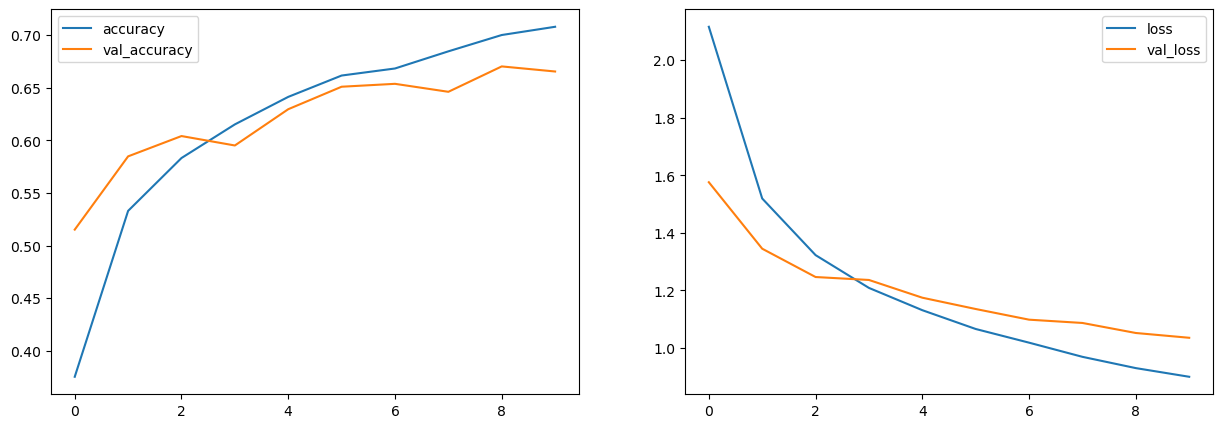

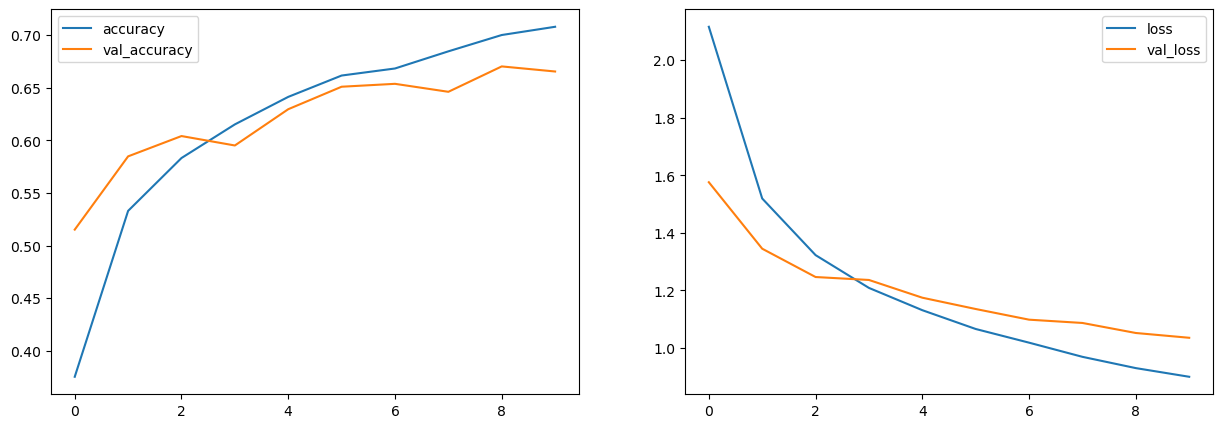

In [7]:
plot_history(model_final)